<a href="https://colab.research.google.com/github/mayait/ClaseAnalisisDatos/blob/main/hall_of_fame/spotify_2022_reguetton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deber de Spotify

**Dilan Garcés**

**Código:320795**

A continuación vamos a realizar ciertos análisis entre diferentes artistas del género urbano, entre ellos: Maluma, Bad Bunny, XxxTentacion y Travis Scott. De esta manera, observaremos diferentes características de artistas del mismo idioma en el género urbano, y además, se compararán entre artistas de habla hispana y habla inglesa para determinar quienes son más populares, quienes tinene canciones más bailables, entre otras cosas. 



## You can find below the explanation of each feature ( past/copy from the Spotify website).

**Acousticness:** A confidence measure from 0.0 to 1.0 of whether the track is 
acoustic. 1.0 represents high confidence the track is acoustic.
Danceability: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

**Energy:** Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

**Instrumentalness:** Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

**Liveness:** Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides a strong likelihood that the track is live.
Loudness: the overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

**Speechiness:** Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audiobook, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

**Valence:** A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

**Tempo:** The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

In [ ]:
# Instala SPOTIPY
! pip install spotipy

     |████████████████████████████████| 138 kB 4.8 MB/s 
     |████████████████████████████████| 63 kB 349 kB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:

import spotipy
spotify = spotipy.Spotify()
import sys
import pandas as pd
from spotipy.oauth2 import SpotifyClientCredentials
from bs4 import BeautifulSoup
import requests
import lxml
import json
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# credenciales de spotify
client_id = "596e2e654f7c4c6db94977c8d9f4f894"
client_secret = "2096de29d91a4e7986ae8739f7d88bd5"

In [ ]:
def get_spotify_credentials():
    # Esta funcion conecta spotify con tus credenciales
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    sp.trace = True
    return sp

In [ ]:
def get_spotify_data(artist_name):

    # obtner la autorizaciones con espotify
    sp = get_spotify_credentials()

    # Busquemos el artista
    results = sp.search(q='artist:' + artist_name, type='artist')
    items = results['artists']['items']
    if len(items) > 0:
        artist = items[0]

    uri = artist['uri']

    # Obtengamos los albums
    results = sp.artist_albums(uri, album_type='album')
    albums = results['items']

    while results['next']:
        results = sp.next(results)
        albums.extend(results['items'])

    uris = []
    track_names = []
    album_names = []

    # Saquemos info de los tracks de los albums
    for album in albums:
        for t in sp.album(album['uri'])['tracks']['items']:
            uris.append(t['uri'])
            track_names.append(t['name'])
            album_names.append(album['name'])
    features = []
    for i in range(len(uris)// 100 + 1):
        fs = sp.audio_features(uris[i*100:min((i+1)*100, len(uris))])
        if fs[0] is not None:
            features.extend(fs)
    print(features)

    # Convirtamos esto a un DataFrame de Pandas!
    dat = pd.DataFrame(features)
    dat['track_name'] = track_names
    dat['album'] = album_names
    dat['artists'] = artist_name


    dat.set_index('track_name', inplace=True)
    dat.drop_duplicates(inplace=True)
    dat = dat[~dat.index.duplicated(keep='first')]

    return dat

In [ ]:
mi_username = "dilansoccer1" # TIP: Prueba el usuario "spotify" tiene listas increibles!!

In [ ]:
def get_user_playlist(username=mi_username, sp=get_spotify_credentials()):
    playlists = sp.user_playlists(username) # Obtener todos los playlist
    while playlists['next']:
        for playlist in playlists['items']:
            print("ID: {} \t Canciones {}\t  Nombre: {} ".
                  format(playlist['id'], playlist['tracks']['total'], playlist['name']))
        playlists = sp.next(playlists)
get_user_playlist()

In [ ]:
# También podemos definir una función que obtenga los datos de la lista de reproducción de un usuario.

def get_spotify_playlist_data(username='spotify', playlist=None, credentials_file=None):

    # Pongamos un limite de tracks a Analizar
    track_number_limit = 1000

    # De nuevo hagamos login en spotify
    # Ven lo util de hacer funciones, no tengo que volverlo a escribir todo!!!!
    sp = get_spotify_credentials()

    # Saquemos todas las playlists de este usuario
    p = None
    results = sp.user_playlists(username)
    playlists = results['items']

    if playlist is None: # Quedemonos con la primera en caso que no haya más
        playlist = playlists[0]['name']

    for pl in playlists:
        if pl['name'] is not None and pl['name'].lower() == playlist.lower():
            p = pl
            break
    while results['next'] and p is None:
        results = sp.next(results)
        playlists = results['items']
        for pl in playlists:
            if pl['name'] is not None and pl['name'].lower() == playlist.lower():
                p = pl
                break

    if p is None:
        print('No hay playlists')
        return

    results = sp.user_playlist(p['owner']['id'], p['id'], fields="tracks,next")['tracks']
    tracks = results['items']
    while results['next'] and len(tracks) < track_number_limit:
        results = sp.next(results)
        if results['items'][0] is not None:
            tracks.extend(results['items'])

    ts = []
    track_names = []

    for t in tracks:
        track = t['track']
        track['album'] = track['album']['name']
        track_names.append(t['track']['name'])
        artists = []
        for a in track['artists']:
            artists.append(a['name'])
        track['artists'] = ', '.join(artists)
        ts.append(track)

    uris = []
    dat = pd.DataFrame(ts)

    dat.drop(['available_markets', 'disc_number', 'external_ids', 'external_urls'], axis=1, inplace=True)

    features = []

    # loop to take advantage of spotify being able to get data for 100 tracks at once
    for i in range(len(dat)// 100 + 1):
        fs = sp.audio_features(dat.uri.iloc[i*100:min((i+1)*100, len(dat))])
        if fs[0] is not None:
            features.extend(fs)

    fs = pd.DataFrame(features)

    dat = pd.concat([dat, fs], axis=1)
    dat['track_name'] = track_names

    # ignore live, remix and deluxe album versions
    mask = [(('live' not in s.lower()) and ('deluxe' not in s.lower())
             and ('remix' not in s.lower())) for s in dat.album.values]
    dat = dat[mask]
    mask2 = [(('remix' not in s.lower()) and
              'remastered' not in s.lower()
             and 'version' not in s.lower()) for s in dat.track_name.values]
    dat = dat[mask2]

    dat.set_index('track_name', inplace=True)
    dat = dat[~dat.index.duplicated(keep='first')]
    dat = dat.T[~dat.T.index.duplicated(keep='first')].T

    return dat

In [ ]:
Travis_Scott = get_spotify_playlist_data(username=mi_username, playlist="travisscott")
Maluma = get_spotify_playlist_data(username=mi_username, playlist="maluma")
XxxTentacion = get_spotify_playlist_data(username=mi_username, playlist="tentacion")
Bad_Bunny = get_spotify_playlist_data(username=mi_username, playlist="badbunny")

In [ ]:
# Convierte en decimal las columnas que vamos a procesar

Travis_Scott['duration_ms'] = Travis_Scott['duration_ms'].astype(float)
Travis_Scott['popularity'] = Travis_Scott['popularity'].astype(float)
Travis_Scott['danceability'] = Travis_Scott['danceability'].astype(float)
Travis_Scott['energy'] = Travis_Scott['energy'].astype(float)
Travis_Scott['loudness'] = Travis_Scott['loudness'].astype(float)
Travis_Scott['mode'] = Travis_Scott['mode'].astype(float)
Travis_Scott['speechiness'] = Travis_Scott['speechiness'].astype(float)
Travis_Scott['acousticness'] = Travis_Scott['acousticness'].astype(float)
Travis_Scott['instrumentalness'] = Travis_Scott['instrumentalness'].astype(float)
Travis_Scott['valence'] = Travis_Scott['valence'].astype(float)
Travis_Scott['tempo'] = Travis_Scott['tempo'].astype(float)

In [ ]:
Maluma['duration_ms'] = Maluma['duration_ms'].astype(float)
Maluma['popularity'] = Maluma['popularity'].astype(float)
Maluma['danceability'] = Maluma['danceability'].astype(float)
Maluma['energy'] = Maluma['energy'].astype(float)
Maluma['loudness'] = Maluma['loudness'].astype(float)
Maluma['mode'] = Maluma['mode'].astype(float)
Maluma['speechiness'] = Maluma['speechiness'].astype(float)
Maluma['acousticness'] = Maluma['acousticness'].astype(float)
Maluma['instrumentalness'] = Maluma['instrumentalness'].astype(float)
Maluma['valence'] = Maluma['valence'].astype(float)
Maluma['tempo'] = Maluma['tempo'].astype(float)

In [ ]:
XxxTentacion['duration_ms'] = XxxTentacion['duration_ms'].astype(float)
XxxTentacion['popularity'] = XxxTentacion['popularity'].astype(float)
XxxTentacion['danceability'] = XxxTentacion['danceability'].astype(float)
XxxTentacion['energy'] = XxxTentacion['energy'].astype(float)
XxxTentacion['loudness'] = XxxTentacion['loudness'].astype(float)
XxxTentacion['mode'] = XxxTentacion['mode'].astype(float)
XxxTentacion['speechiness'] = XxxTentacion['speechiness'].astype(float)
XxxTentacion['acousticness'] = XxxTentacion['acousticness'].astype(float)
XxxTentacion['instrumentalness'] = XxxTentacion['instrumentalness'].astype(float)
XxxTentacion['valence'] = XxxTentacion['valence'].astype(float)
XxxTentacion['tempo'] = XxxTentacion['tempo'].astype(float)

In [ ]:
Bad_Bunny['duration_ms'] = Bad_Bunny['duration_ms'].astype(float)
Bad_Bunny['popularity'] = Bad_Bunny['popularity'].astype(float)
Bad_Bunny['danceability'] = Bad_Bunny['danceability'].astype(float)
Bad_Bunny['energy'] = Bad_Bunny['energy'].astype(float)
Bad_Bunny['loudness'] = Bad_Bunny['loudness'].astype(float)
Bad_Bunny['mode'] = Bad_Bunny['mode'].astype(float)
Bad_Bunny['speechiness'] = Bad_Bunny['speechiness'].astype(float)
Bad_Bunny['acousticness'] = Bad_Bunny['acousticness'].astype(float)
Bad_Bunny['instrumentalness'] = Bad_Bunny['instrumentalness'].astype(float)
Bad_Bunny['valence'] = Bad_Bunny['valence'].astype(float)
Bad_Bunny['tempo'] = Bad_Bunny['tempo'].astype(float)

In [ ]:
# Podemos hacer una lista de todas las columnas que queremos obtener sumatorias
columnas = ['valence', 'speechiness', 'instrumentalness', 'energy', 'danceability', 'acousticness', "popularity"]

In [ ]:
Maluma_data = Maluma[columnas].mean().to_frame().transpose()
XxxTentacion_data = XxxTentacion[columnas].mean().to_frame().transpose()
Bad_Bunny_data = Bad_Bunny[columnas].mean().to_frame().transpose()
Travis_Scott_data = Travis_Scott[columnas].mean().to_frame().transpose()

In [ ]:
Maluma_data['playlist'] = "Maluma"
Bad_Bunny_data['playlist'] = "Bad_Bunny"
XxxTentacion_data['playlist'] = "XxxTentacion"
Travis_Scott_data['playlist'] = "Travis_Scott"


# **Diagrama de Patel** 

**¿ Qué artista  utiliza mas instrrumentalidad en sus canciones?**

In [ ]:
all_means

,valence,speechiness,instrumentalness,energy,danceability,acousticness,popularity,playlist
0,0.691021,0.132618,0.000065,0.738061,0.746273,0.272285,75.636364,Maluma
0,0.469552,0.126369,0.000167,0.640517,0.740103,0.336638,75.000000,Bad_Bunny
0,0.298645,0.079507,0.000234,0.613966,0.662034,0.143325,75.206897,Travis_Scott
0,0.396763,0.184413,0.006662,0.510927,0.682367,0.369027,77.166667,XxxTentacion


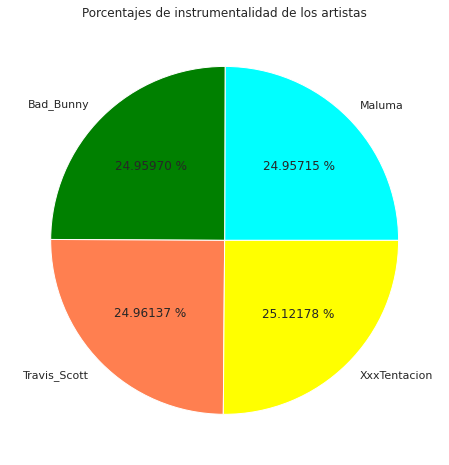

In [ ]:

 
etiquetas = ['Maluma','Bad_Bunny','Travis_Scott','XxxTentacion']
valores = [0.000065+1,0.000167+1,0.000234+1,0.006662+1]
colores = ['cyan','green','coral','yellow']
 
plt.pie(x=valores, labels=etiquetas, colors = colores,autopct="%0.5f %%")
 
plt.title('Porcentajes de instrumentalidad de los artistas')
 
plt.show()

# Conclusiones:

**Gracias al diagrama de pastel podemos concluir ciertas situaciones.**


1.   Los artistas del género urbano en el idioma Inglés son los que más instrumentalidad tienen en sus canciones.
2.   Los artistas del género urbano en el idioma español son los que menos instrumentalidad usan, es decir, de acuerdo al contexto de lo que es Instrumentalidad tanto Maluma como Bad Bunny rapean menos que los artistas  en Inglés.



# **¿ Quién es el artista más popular?**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

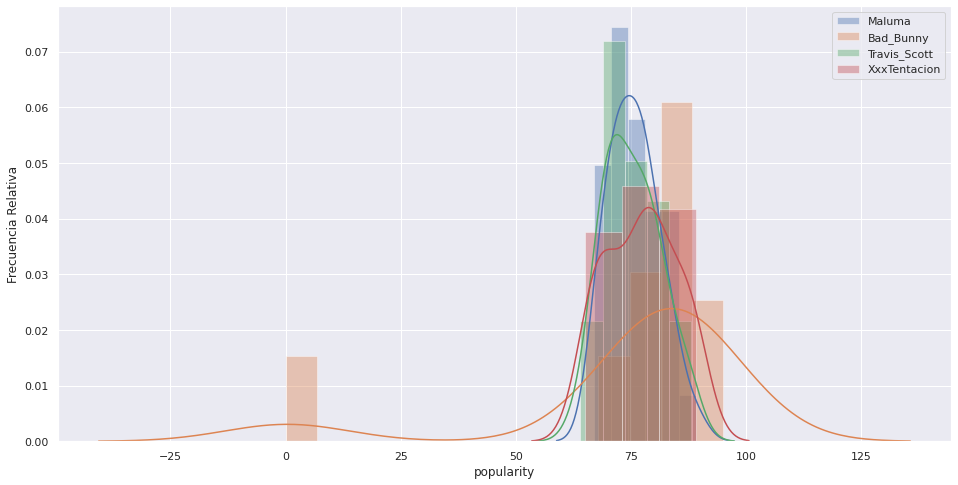

In [ ]:

sns.distplot(Maluma['popularity'],  kde=True, label='Maluma')
sns.distplot(Bad_Bunny['popularity'], kde=True, label='Bad_Bunny')
sns.distplot(Travis_Scott['popularity'], kde=True, label='Travis_Scott')
sns.distplot(XxxTentacion['popularity'], kde=True, label='XxxTentacion')
sns.set(rc = {'figure.figsize':(16,8)})
plt.ylabel("Frecuencia Relativa")
plt.legend()

plt.show()

# Conclusión:

**Podemos observar gracias al histogramas que el cantante Maluma es el que más canciones populares tiene con respecto a Travis Scott, Bad Bunny y por último el cantante XxxTentación. Además, podemos darnos cuenta que el artista Bad Bunny es el que más variación tiene en sus canciones, es decir, tiene ciertas canciones que no llegan a la media de popularidad.**

# **Diagramas de dispersión por artistas para determinar si el hecho de que sus canciones son populares significa que son bailables.**

In [ ]:
X = Maluma['popularity'].values.reshape(-1,1)
y = Maluma['danceability'].values.reshape(-1,1)

#Creamos la regresión
reg = LinearRegression()
reg.fit(X, y)

LinearRegression()

In [ ]:
intercepto = reg.intercept_[0]
coeficiente = reg.coef_[0][0]

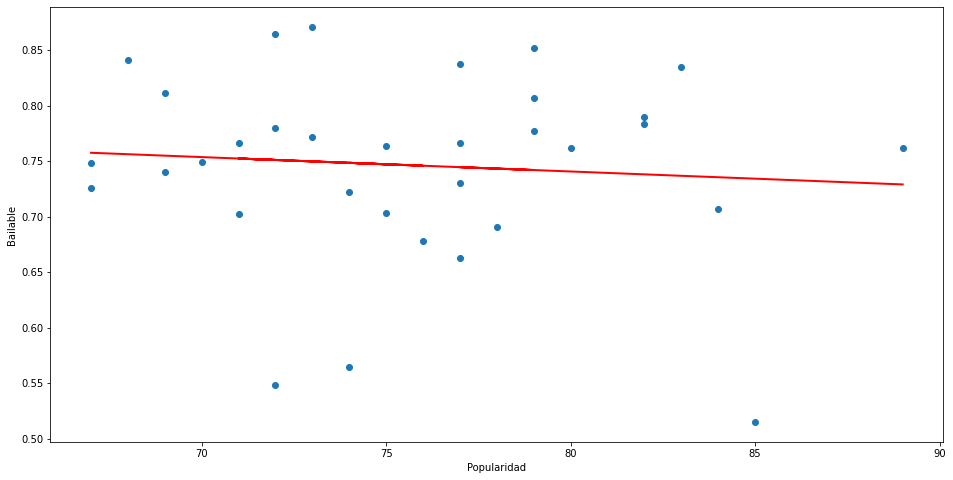

In [ ]:
predictions = reg.predict(X)

plt.figure(figsize=(16, 8))

# Dibujamos un gráfico de dispersión con Matplotlib para dos variables
plt.scatter(
    Maluma['popularity'],
    Maluma['danceability'],
)

# Dibujamos la linea
plt.plot(
    Maluma['popularity'],
    predictions,
    c='red',
    linewidth=2
)

# Ponemos etiquetas al chart
plt.xlabel("Popularidad")
plt.ylabel("Bailable")
plt.show()

**En este diagrama de dispersión se puede observar que existe una correlación negativa entre las variables, es decir, mientras más popular es una canción del artista Maluma menos bailable es. De esta manera, podemos concluir que no por el hecho de que una canción del artista Maluma sea popular tiene que ser bailable.**

In [ ]:
X = Bad_Bunny['popularity'].values.reshape(-1,1)
y = Bad_Bunny['danceability'].values.reshape(-1,1)

#Creamos la regresión
reg = LinearRegression()
reg.fit(X, y)

LinearRegression()

In [ ]:
intercepto = reg.intercept_[0]
coeficiente = reg.coef_[0][0]

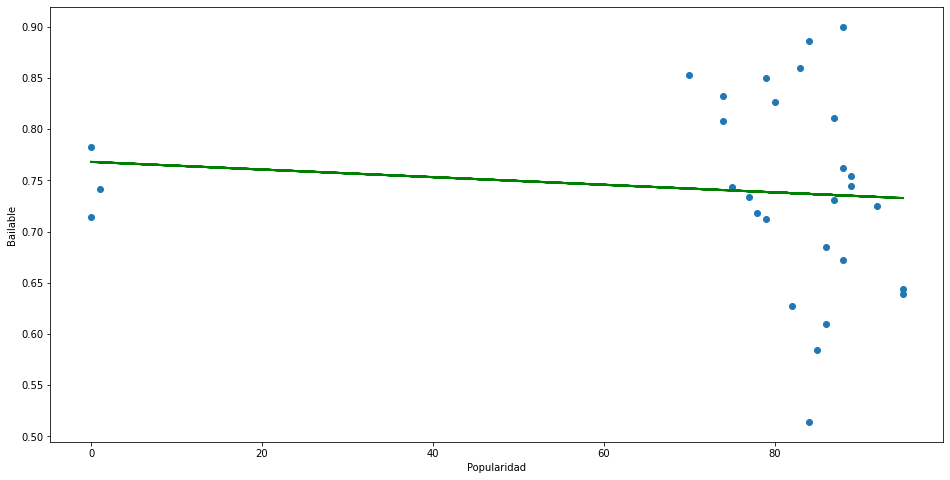

In [ ]:
predictions = reg.predict(X)

plt.figure(figsize=(16, 8))

# Dibujamos un gráfico de dispersión con Matplotlib para dos variables
plt.scatter(
    Bad_Bunny['popularity'],
    Bad_Bunny['danceability'],
)

# Dibujamos la linea
plt.plot(
    Bad_Bunny['popularity'],
    predictions,
    c='green',
    linewidth=2
)

# Ponemos etiquetas al chart
plt.xlabel("Popularidad")
plt.ylabel("Bailable")
plt.show()

**En este diagrama de dispersión se puede observar que existe prácticamente nula correlación entre las variables, es decir,en la muestra del playlist que se recabo para este análisis se evidencia que existe cierta correlación entre canciones que son muy polulares y al mismo tiempo son my bailables. Sin embargo, gracias a la línea de predicción podemos determinar que mientras más polulares sean las canciones menos bailables serán.**

In [ ]:
X = XxxTentacion['popularity'].values.reshape(-1,1)
y = XxxTentacion['danceability'].values.reshape(-1,1)

#Creamos la regresión
reg = LinearRegression()
reg.fit(X, y)

LinearRegression()

In [ ]:
intercepto = reg.intercept_[0]
coeficiente = reg.coef_[0][0]

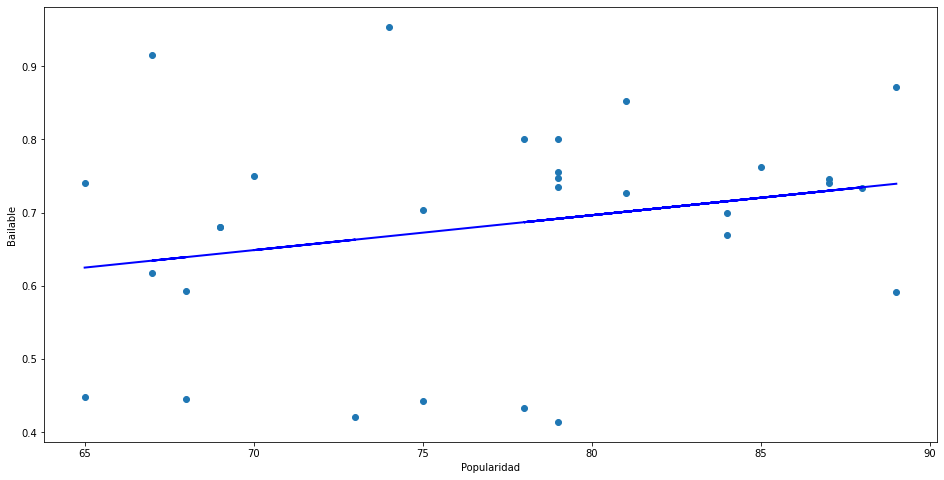

In [ ]:
predictions = reg.predict(X)

plt.figure(figsize=(16, 8))

# Dibujamos un gráfico de dispersión con Matplotlib para dos variables
plt.scatter(
    XxxTentacion['popularity'],
    XxxTentacion['danceability'],
)

# Dibujamos la linea
plt.plot(
    XxxTentacion['popularity'],
    predictions,
    c='blue',
    linewidth=2
)

# Ponemos etiquetas al chart
plt.xlabel("Popularidad")
plt.ylabel("Bailable")
plt.show()

**Gracias a este diagrama de dispersión podemos darnos cuenta que existe una correlación positiva entre las variables de Pupularidad y Bailabilidad de las canciones del artista Xxx Tenatacion, es decir, mientras sus canciones sean más populares son más bailables.**

In [ ]:
X = Travis_Scott['popularity'].values.reshape(-1,1)
y = Travis_Scott['danceability'].values.reshape(-1,1)

#Creamos la regresión
reg = LinearRegression()
reg.fit(X, y)

LinearRegression()

In [ ]:
intercepto = reg.intercept_[0]
coeficiente = reg.coef_[0][0]

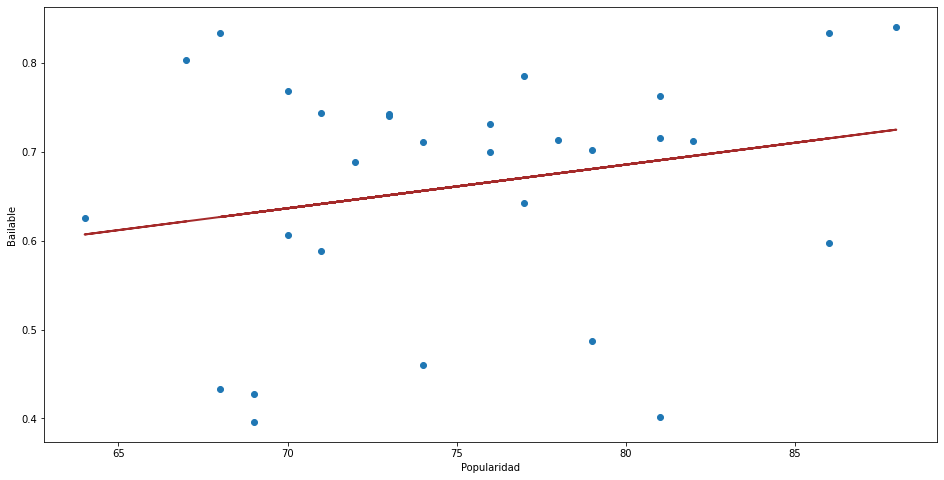

In [ ]:
predictions = reg.predict(X)

plt.figure(figsize=(16, 8))

# Dibujamos un gráfico de dispersión con Matplotlib para dos variables
plt.scatter(
    Travis_Scott['popularity'],
    Travis_Scott['danceability'],
)

# Dibujamos la linea
plt.plot(
    Travis_Scott['popularity'],
    predictions,
    c='brown',
    linewidth=2
)

# Ponemos etiquetas al chart
plt.xlabel("Popularidad")
plt.ylabel("Bailable")
plt.show()

**Gracias a este diagrama de dispersión podemos darnos cuenta que existe una correlación positiva entre las variables de Pupularidad y Bailabilidad de las canciones del artista Travis Scott, es decir, mientras sus canciones sean más populares son más bailables.**

# Conclusión final:

**Nos podemos dar cuenta gracias a los diagramas de dispersión que las canciones del género urbano de artistas de habla hispana tienen una correlación negativa entre sus variables de Popularidad y Bailabilidad, es decir, mientras sus canciones son más populares quiere decir que son menos bailables.**

**Mientras que por el contrario, las canciones del género urbano de artistas de habla inglesa tienen una correlación positiva en sus variables de Popularidad y Bailabilidad, es decir, mientras sus canciones son más populares quiere decir que son más bailables.**

# **¿ Qué cantante tiene la música más alegre?**

In [ ]:
# Unimos los dataframes

In [ ]:
all_means = pd.concat([Maluma_data,Bad_Bunny_data,Travis_Scott_data,XxxTentacion_data])


In [ ]:
# el indice de las filas deberia ser el playlist
all_means.set_index('playlist')

,valence,speechiness,instrumentalness,energy,danceability,acousticness,popularity
playlist,,,,,,,
Maluma,0.691021,0.132618,0.000065,0.738061,0.746273,0.272285,75.636364
Bad_Bunny,0.469552,0.126369,0.000167,0.640517,0.740103,0.336638,75.000000
Travis_Scott,0.298645,0.079507,0.000234,0.613966,0.662034,0.143325,75.206897
XxxTentacion,0.396763,0.184413,0.006662,0.510927,0.682367,0.369027,77.166667


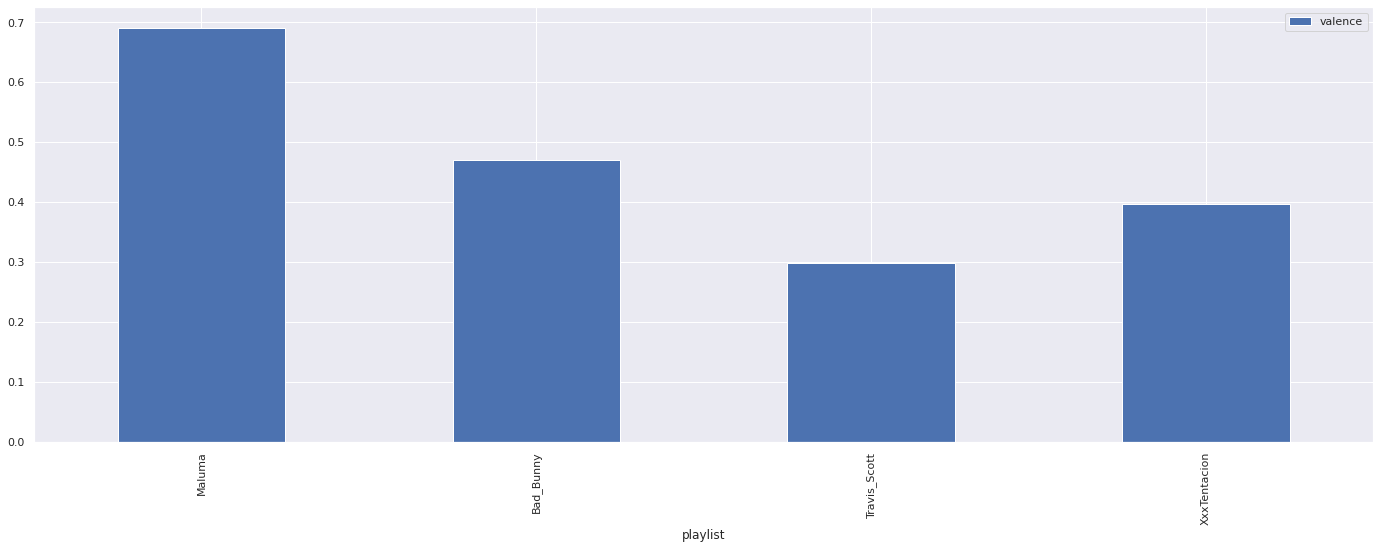

In [ ]:
all_means.plot(kind='bar', y="valence",x="playlist")

# **Conclusiones**

**Gracias al diagrama de barras se puede observar que el cantante Maluma es quien posee las canciones más alegres entre todos los demás artistas. Al mismo tiempo, podemos observar que el cantante Travis Scott vive en una depresión total con respecto a los demás artistas.**

**Además, podemos hacer cierta relación y determinar que los cantante del género urbano de habla hispana tienen canciones más alegres que los cantantes de habla inglesa.**

# **¿ Qué artista tiene más energía en sus canciones**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

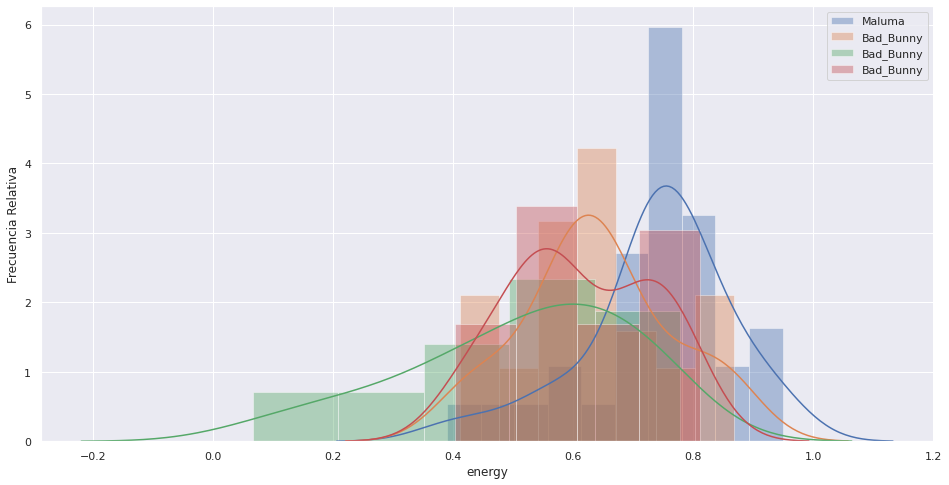

In [ ]:
sns.distplot(Maluma['energy'],  kde=True, label='Maluma')
sns.distplot(Bad_Bunny['energy'], kde=True, label='Bad_Bunny')
sns.distplot(XxxTentacion['energy'], kde=True, label='Bad_Bunny')
sns.distplot(Travis_Scott['energy'], kde=True, label='Bad_Bunny')


plt.ylabel("Frecuencia Relativa")
plt.legend()

plt.show()

# Conclusiones:


**1.   Gracias al diagrama se puede identificar que el artista Maluma es quien realiza sus canciones con más energía, es decir, sus pistas son más fuertes, rápidas y ruidosas que los demás.**


**2.   Se puede observar que el artista Bad Bunny es quien posee mayor varianza en sus pistas, es decir, en muchas de ellas tiene más energía que en otras.**



# **Conclusiones Genrales**

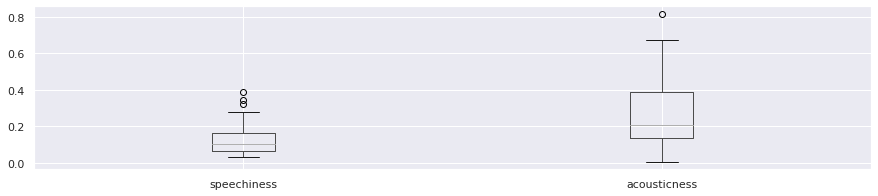

In [ ]:
Maluma.boxplot(column=['speechiness', 'acousticness' ],figsize=(15,3));




*   Se puede observar en el diagrama de cajas y bigotes de Acousticness que el artista Maluma tiene un 50% de sus canciones dentro de un rango de canciones que no terminan de ser acústicas como tal, con un outlayer, es decir, una canción que es muy acústica.
*   Se puede observar en el diagrama de cajas y bigotes de Speechiness que el artista Maluma tiene un 50% de sus canciones dentro de un rango de canciones que representan que el artista en su gran mayoría de canciones utiliza sinplemente música con ciertos outlayer, es decir, canciones que son tanto música como momentos hablados.







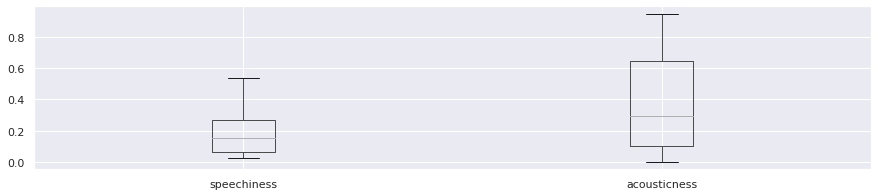

In [ ]:

XxxTentacion.boxplot(column=['speechiness', 'acousticness' ],figsize=(15,3));

*   Se puede observar en el diagrama de cajas y bigotes de Acousticness que el artista XxxTentacion tiene un 50% de sus canciones dentro de un rango de canciones que van desde poco acústicas a muy acústicas, y el 50% e canciones restantes estarían en su mayoria en muy acústicas.
*   Se puede observar en el diagrama de cajas y bigotes de Speechiness que el artista XxxTentacion tiene un 50% de sus canciones dentro de un rango de canciones que representan que el artista en su gran mayoría de canciones utiliza sinplemente música, y el otro 50% son canciones que tampoco utilizan momentos hablados.


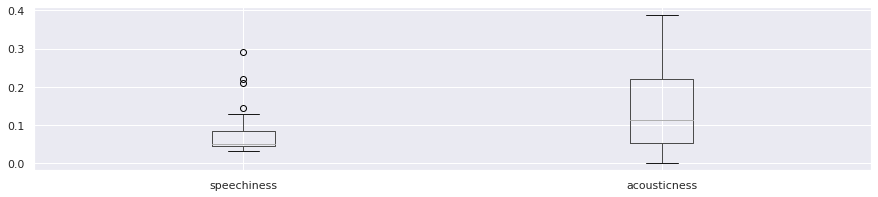

In [ ]:
Travis_Scott.boxplot(column=['speechiness', 'acousticness' ],figsize=(15,3));

*   Se puede observar en el diagrama de cajas y bigotes de Acousticness que el artista Travis Scott tiene un 50% de sus canciones dentro de un rango de canciones que van desde poco acústicas a acústicas, y el 50% e canciones restantes estarían en su mayoria en muy acústicas.
*   Se puede observar en el diagrama de cajas y bigotes de Speechiness que el artista Travis Scott  tiene un 50% de sus canciones dentro de un rango de canciones que representan que el artista en su gran mayoría de canciones utiliza sinplemente música, y existen ciertos outlyers que nos indican que en varias canciones el cantante si utiliza momentos hablados en sus canciones.

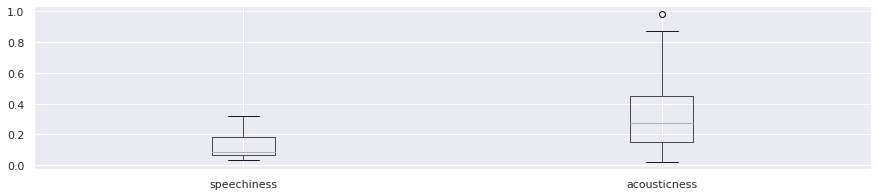

In [ ]:
Bad_Bunny.boxplot(column=['speechiness', 'acousticness' ],figsize=(15,3));

*   Se puede observar en el diagrama de cajas y bigotes de Acousticness que el artista Bad Bunny tiene un 50% de sus canciones dentro de un rango de canciones que van desde poco acústicas a muy acústicas, y cieto outlayer que nos indica una canción muy acústica dentro de su playlist.
*   Se puede observar en el diagrama de cajas y bigotes de Speechiness que el artista Bad Bunny tiene un 50% de sus canciones dentro de un rango de canciones que representan que el artista en su gran mayoría de canciones utiliza sinplemente música, y el otro 50% son canciones que tampoco utilizan momentos hablados.